In [15]:
# many functions have been defined but written down in different ipynb files, for clarity. Import those (%run)
%run Functions.ipynb
%run Functions_visualization.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [5]:
# open protection_score to generate list of HLA alleles with 
# a)  known effect on HIV progression of corresponding allele serotype: 'HLAknown'
# b)  known effect on HIV progression of specific allele genotype: 'HLAobvious'
%store -r protection_score
protection_df = pd.DataFrame(protection_score.items()).sort_values(1)
HLAknown = list(protection_df.loc[protection_df[1]!= 'unknown'][0])
%store HLAknown
protection_df = pd.DataFrame(protection_score.items()).sort_values(1)
HLAobvious = pd.concat([protection_df[protection_df[1] == -10], protection_df[protection_df[1] == 10]])
%store HLAobvious

Stored 'HLAknown' (list)
Stored 'HLAobvious' (DataFrame)


## Comparison of all Protective vs Detrimental HLA alleles, no. of bound peptides


In [3]:
# import netMHCpan data for all proteins in HIVproteome and group accessory proteins as 'acc'
proteins_grouped = group_for_dict_abs() 

# Create dictionary of counted no. of binding peptides per strain, per HLA allele
# cutoff for a peptide being bound by HLA is 2.0 
grouped_abs = to_dict_abs_grouped(proteins_grouped, 2.0) 
%store proteins_grouped
%store grouped_abs

env gag pol tat rev nef vpr vpu vif gag acc pol envStored 'proteins_grouped' (dict)
Stored 'grouped_abs' (dict)



In [7]:
# Input: grouped_abs dictionary, structure d = [protein][strain][allele]
# Contains counts of binding peptides per allele, per strain, with binding rank below 2.0
# Additional input: protection_score dictionary.

%store -r grouped_abs 
grouped_abs = dict_transpose_ABC_CAB(grouped_abs) #rearrange dict to new structure: [allele][protein][strain]

df = pd.DataFrame(columns = ['allele', 'protection', 'peptides']) # initiate df with columnnames
for allele in grouped_abs: 
    if protection_score[allele] != 'unknown' and protection_score[allele] != 0: # select HLA alleles with known score
        if protection_score[allele] < 0: # group these alleles in two groups, P/D
            protection = 'Detrimental'
        else:
            protection = 'Protective'
        summeans = 0 # Initiate variables, no of peptides per allele for all proteins
        for protein in grouped_abs[allele]: # calculate mean and stdev of all strains for each allele/protein, and add to sum
            mean = np.mean(grouped_abs[allele][protein].values())
            summeans += mean
        row = [allele, protection, summeans] # create list of three variables that will form one row in final dataframe
        df = df.append(pd.DataFrame([row], columns = ['allele', 'protection', 'peptides'])) # append row for each allele to df


MannwhitneyuResult(statistic=68.0, pvalue=0.42146444720525489)


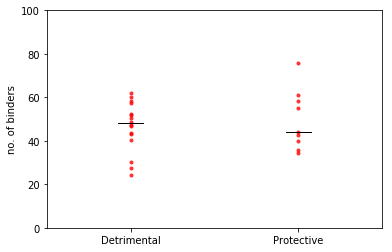

In [8]:
scatter_dot_plot_mannwhitney(df, 'peptides', 'no. of binders', 0, 100)

## Relative binding preference
Stacked bar charts of different proteins in HIV; Env, Pol, Gag, Accessory (Rev, Tat, Nef, Vif, Vpr, Vpu)

Group accessory proteins together. Grouping performed after netMHCpan results, if protein sequences were to be combined beforehand the predictor tool would generate 'peptides' from two proteins

In [31]:
# First, import netMHCpan data and group accessory proteins,  
# append all data to one big dataframe with annotated protein origin (env/gag/pol/acc)
proteins_grouped_rel = group_for_dict_rel() 

# Next, create dict containing relative binding preference for peptides from one of 4 proteins 
# within top100 strongest binding peptides of all proteins taken together
relative_preference_final = to_dict_rel_grouped(proteins_grouped_rel) 
%store relative_preference_final
# hierarchy of relative_preference_final: [protein][allele][strain] = count

env gag pol tat rev nef vpr vpu vifStored 'relative_preference_final' (dict)



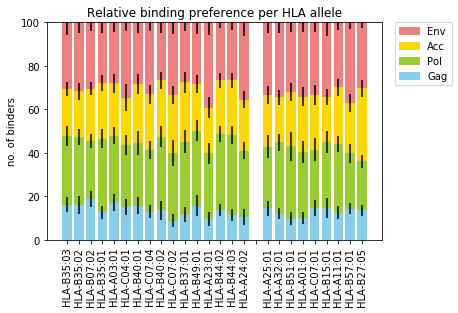

In [34]:
%store -r HLAknown 
# HLAknown is required for rel_bar_chart function
%store -r relative_preference_final 
rel_bar_chart(relative_preference_final)

## Clade comparison

In this section, we will zoom in on the most prevalent HIV clades, namely HIV1-A1, HIV1-B, HIV1-C, HIV2-A and HIV2-B. This serves to check the hypothesis that above data have been occluded by averaging between perhaps very different HIV clades, and that differences between HLA alleles will be more pronounced when clades are segregated.

In [ ]:
# Generate list with selected reference strains for the most prevalent HIV clades. For future use
Reflist = ['Ref_B_FR_83_HXB', 'B_GH_86_D205_AL', 'B_JP_01_IMCJ_KR', 'Ref_B_NL_00_671', 'Ref_A1_AU_03_PS', 
              'B_CI_x_20_56_AB', 'Ref_A1_UG_92_92', 'Ref_C_BR_92_BR0', 'A_DE_x_BEN_M305', 'B_CI_88_UC1_L07', 
              'A_GM_87_D194_J0', 'Ref_C_ET_86_ETH', 'Ref_C_ZA_04_04Z', 'Ref_A1_RW_92_92', 'B_CI_x_EHO_U272', 
              'Ref_B_TH_90_BK1', 'Ref_C_IN_95_95I', 'Ref_B_US_98_105', 'A_GH_x_GH1_M308', 'A_CI_88_UC2_U38']
%store Reflist

In [35]:
%store -r grouped_abs 
# Add additional layer of hierarchy in grouped_abs dictionary, 
# grouping reference strains together when belonging to the same clade
grouped_Clade_ABC = add_clades(grouped_abs) 

# select from grouped_Clade_ABC only those allele genotypes with known protection score 
grouped_Clade_ABC_obv = {HLA: grouped_Clade_ABC[HLA] for HLA in HLAobvious[0]}

%store grouped_Clade_ABC
%store grouped_Clade_ABC_obv

Stored 'grouped_Clade_ABC' (dict)
Stored 'grouped_Clade_ABC_obv' (dict)


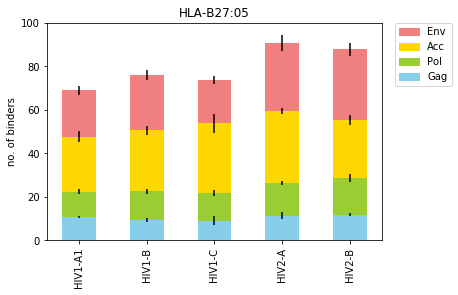

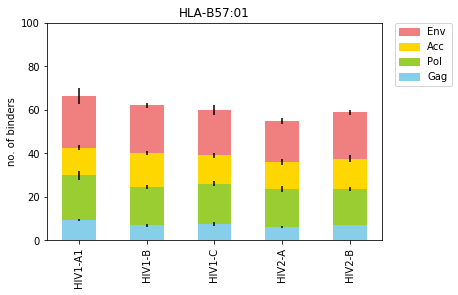

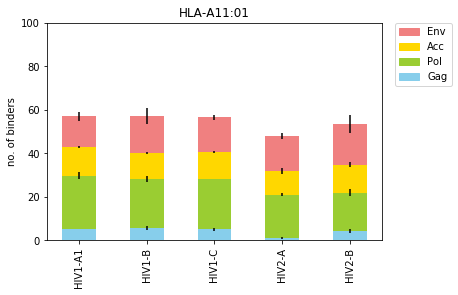

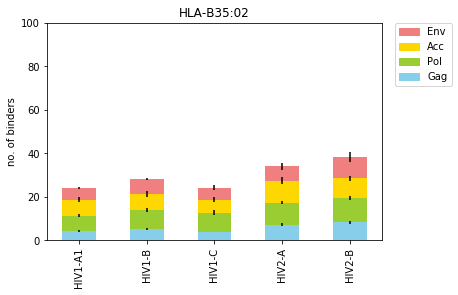

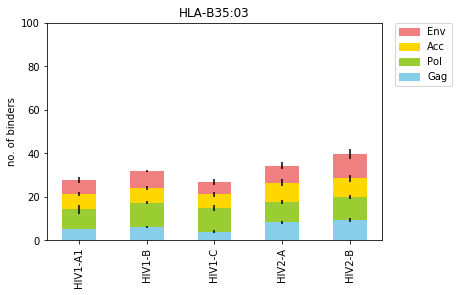

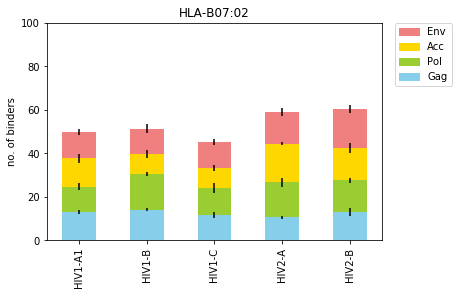

In [36]:
# grouped_Clade_ABC_obv structure: [allele][protein][clade][strain]
%store -r grouped_Clade_ABC_obv

for allele in 'HLA-B27:05', 'HLA-B57:01', 'HLA-A11:01', 'HLA-B35:02', 'HLA-B35:03', 'HLA-B07:02': 
    #will print in this order, top3 are Detrimental, bottom3 are Protective
    bar_chart_clades(allele, grouped_Clade_ABC_obv)